In [2]:
import numpy as np
import tensorflow as tf
import glob
import os
import gzip
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

crop_dataset_dir = r"C:\Users\prade\Documents\CloudxLab\Codes\Crop_Pest_Detection\archive"
categories = ['Cashew','Cassava','Maize','Tomato']


In [4]:
epochs = 10
batch_size = 64
image_size = (128, 128)
input_shape = (128, 128, 3)
learng_rate = 0.001
max_images_per_category = 5000

In [5]:
def get_disease_category_by_path(file_path):
    return file_path.split("\\")[8]

def get_plant_category_by_path(file_path):
  disease_category = get_disease_category_by_path(file_path)
  return disease_category.split(" ")[0]


def process_images(images):
  image_list = []

  for filename in images:
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, image_size)
    img = tf.image.convert_image_dtype(img, tf.float32)

    image_list.append(img)

  return image_list

def clean_image_dataframe(df):
  for image in df['filename']:
    try:
      img = tf.io.read_file(image)
      img = tf.io.decode_jpeg(img)
    except:
      index = df[(df.filename == image)].index
      df = df.drop(index)
  return df

In [6]:
def encode_label(label):
  if label == 'Cashew':
    return 0
  elif label == 'Cassava':
    return 1
  elif label == 'Maize':
    return 2
  elif label == 'Tomato':
    return 3
  else:
    return -1

In [7]:
filenames = []
plant_categ = []
disease_categ = []

# sort categories and filenames

for (root,dirs,files) in os.walk(crop_dataset_dir):
  for filename in files:
    fname = str(root + "\\" + filename)
    filenames.append(fname)

    plant_categ.append(get_plant_category_by_path(fname))
    disease_categ.append(get_disease_category_by_path(fname))

# Create DataFrame
data = {
    'filename': filenames,
    'plant_category': plant_categ,
    'disease_category': disease_categ
}
df = pd.DataFrame(data)
df = df.sample(frac=1)

print(df.head(10))

                                                filename plant_category  \
6508   C:\Users\prade\Documents\CloudxLab\Codes\Crop_...         Cashew   
971    C:\Users\prade\Documents\CloudxLab\Codes\Crop_...         Cashew   
17246  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...          Maize   
14615  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...          Maize   
963    C:\Users\prade\Documents\CloudxLab\Codes\Crop_...         Cashew   
22678  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...         Tomato   
19012  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...          Maize   
10365  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...        Cassava   
6835   C:\Users\prade\Documents\CloudxLab\Codes\Crop_...        Cassava   
640    C:\Users\prade\Documents\CloudxLab\Codes\Crop_...         Cashew   

                disease_category  
6508             Cashew red rust  
971           Cashew anthracnose  
17246            Maize leaf spot  
14615           Maize grasshoper  

Length of DF: 25124
Number of images per category:
plant_category
Cashew     6549
Cassava    7508
Maize      5288
Tomato     5779
dtype: int64


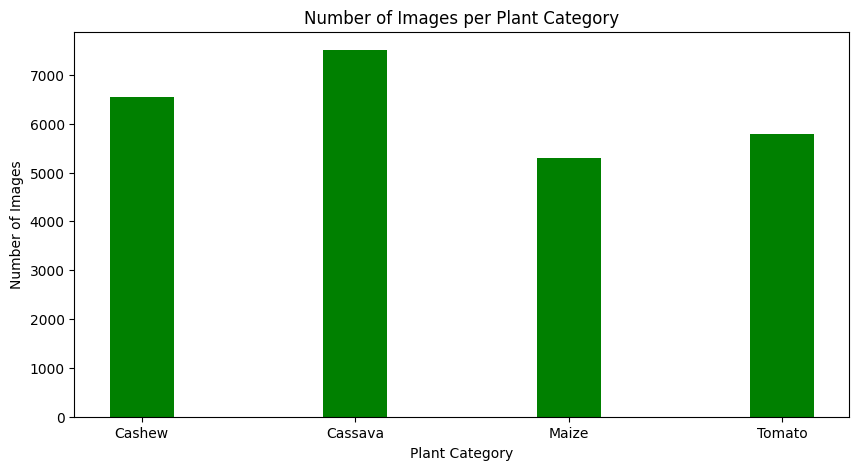

In [8]:
df = clean_image_dataframe(df)
print(f"Length of DF: {len(df['filename'])}")

categ_size = df.groupby('plant_category').size()
print(f"Number of images per category:\n{categ_size}")

categs = df['plant_category'].sort_values().unique()

fig = plt.figure(figsize=(10, 5))

plt.bar(categs, categ_size,color='green',width=0.3)
plt.xlabel('Plant Category')
plt.ylabel('Number of Images')
plt.title('Number of Images per Plant Category')
# plt.xticks(rotation=45)
plt.show()

In [9]:
# Limit the number of images per category
# cashew_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Cashew' == x][0:MAX_IMAGES_PER_CATEGORY]
cashew_df = [df['filename'].values[i] for i,x in enumerate(df['plant_category'].values) if 'Cashew' == x][0:max_images_per_category]
cassava_df = [df['filename'].values[i] for i,x in enumerate(df['plant_category'].values) if 'Cassava' == x][0:max_images_per_category]
maize_df = [df['filename'].values[i] for i,x in enumerate(df['plant_category'].values) if 'Maize' == x][0:max_images_per_category]
tomato_df = [df['filename'].values[i] for i,x in enumerate(df['plant_category'].values) if 'Tomato' == x][0:max_images_per_category]  

crop_dataset = []

def create_dataset(fnames,label):
  for fname in fnames:
    data_sub = []
    data_sub.append(fname)
    data_sub.append(encode_label(label))
    crop_dataset.append(data_sub)

create_dataset(cashew_df, 'Cashew')
create_dataset(cassava_df, 'Cassava') 
create_dataset(maize_df, 'Maize')
create_dataset(tomato_df, 'Tomato')

unbalanced_dataset_size = len(df['filename'].unique())
balanced_dataset_size = len(crop_dataset)
loss = round((1- balanced_dataset_size/unbalanced_dataset_size) * 100, 2)

print(f"Unbalanced dataset size: {unbalanced_dataset_size}")
print(f"Balanced dataset size: {balanced_dataset_size}")

Unbalanced dataset size: 25124
Balanced dataset size: 20000


In [10]:
crop_dataset_df = pd.DataFrame(crop_dataset, columns=['filename', 'label'])
print(f"Crop dataset:\n{crop_dataset_df.head()}")

Crop dataset:
                                            filename  label
0  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...      0
1  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...      0
2  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...      0
3  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...      0
4  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...      0


In [10]:
# x = crop_dataset_df['filename']
# y = crop_dataset_df['label']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [11]:
from functools import partial

# Create a generator that loads and preprocesses images lazily
def image_label_generator(filenames, labels):
    for fname, label in zip(filenames, labels):
        img = tf.io.read_file(fname)
        img = tf.io.decode_jpeg(img)
        img = tf.image.resize(img, image_size)
        img = tf.image.convert_image_dtype(img, tf.float32)
        yield img, label

# Train/test split
x = crop_dataset_df['filename'].values
y = crop_dataset_df['label'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# Create tf.data.Datasets using from_generator
train_ds = tf.data.Dataset.from_generator(
    lambda: image_label_generator(x_train, y_train),
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

# test_ds = tf.data.Dataset.from_generator(
#     lambda: image_label_generator(x_test, y_test),
#     output_signature=(
#         tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
#         tf.TensorSpec(shape=(), dtype=tf.int32)
#     )
# )

# Shuffle, batch, and prefetch for performance
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


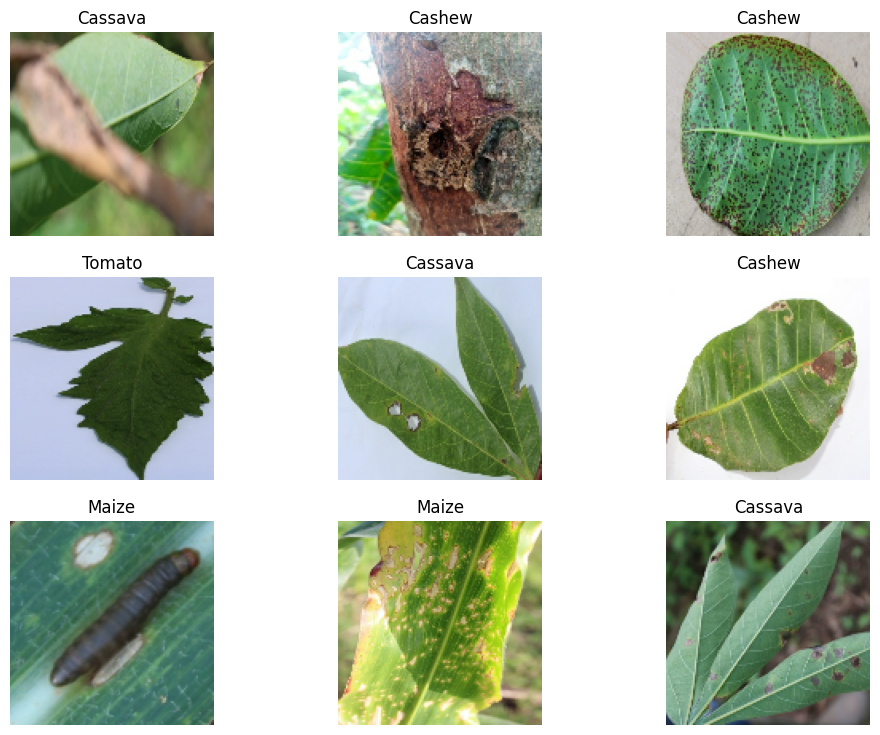

In [12]:
plt.figure(figsize=(12,9))
for image, label in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(categories[label[i]])
    plt.axis("off")

In [13]:
strt_point = max_images_per_category+1

cashew_df = [df['filename'].values[i] for i,x in enumerate(df['plant_category'].values) if 'Cashew' == x][strt_point:]
cassava_df = [df['filename'].values[i] for i,x in enumerate(df['plant_category'].values) if 'Cassava' == x][strt_point:]
maize_df = [df['filename'].values[i] for i,x in enumerate(df['plant_category'].values) if 'Maize' == x][strt_point:]
tomato_df = [df['filename'].values[i] for i,x in enumerate(df['plant_category'].values) if 'Tomato' == x][strt_point:]  

test_crop_dataset = []

def create_test_dataset(fnames,label):
    for fname in fnames:
        data_sub = []
        data_sub.append(fname)
        data_sub.append(encode_label(label))
        test_crop_dataset.append(data_sub)

create_test_dataset(cashew_df, 'Cashew')    
create_test_dataset(cassava_df, 'Cassava')
create_test_dataset(maize_df, 'Maize')
create_test_dataset(tomato_df, 'Tomato')

test_crop_dataset_size = len(test_crop_dataset)
print(f"Test crop dataset size: {test_crop_dataset_size}")

test_crop_dataset_df = pd.DataFrame(test_crop_dataset, columns=['filename', 'label'])
print(f"Test crop dataset:\n{test_crop_dataset_df.head()}")

test_images  = process_images(test_crop_dataset_df['filename'])
test_labels = test_crop_dataset_df['label']
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.batch(batch_size)#.prefetch(tf.data.AUTOTUNE)


Test crop dataset size: 5120
Test crop dataset:
                                            filename  label
0  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...      0
1  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...      0
2  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...      0
3  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...      0
4  C:\Users\prade\Documents\CloudxLab\Codes\Crop_...      0


In [19]:
base_model = tf.keras.applications.VGG16(
    include_top = False,
    input_shape=input_shape,
    weights="imagenet"
)
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [23]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.2),
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(4)
# ])

model = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learng_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)




# Train
history = model.fit(train_ds, epochs=epochs,validation_data=test_ds)

# Evaluate
print(model.evaluate(test_ds, return_dict=True))

Epoch 1/10
235/235 [==============================] - 752s 3s/step - loss: 0.8673 - accuracy: 0.7831 - val_loss: 0.3256 - val_accuracy: 0.8787
Epoch 2/10
235/235 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.8719

In [ ]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels= categories,
            yticklabels=categories,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
print(y_pred)

In [ ]:
plt.figure(figsize=(12,9))
for image, label in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(f"Predicted: {categories[y_pred[i]]} - True: {categories[y_true[i]]}")
    plt.axis("off")